In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_palette(sns.color_palette())
from tqdm.notebook import tqdm
from plotnine import *
import pandas as pd

from mizani.palettes import brewer_pal
from palettable import colorbrewer
palette=brewer_pal(type='qual', palette='Set1')

from mcmcmd.samplers import *
from mcmcmd.tests import *

import joblib

# Helper functions

In [2]:
'''
Bayesian Lasso. Reversible Jump MCMC posterior sampler
Model based on (Chen, Wang, and McKeown 2011)
'''
class bayes_lasso_sampler(model_sampler):
    def __init__(self, N=1, p=3, Lambda=1, tau=1, alpha_sigma2=3, beta_sigma2=1, epsilon_update=1, epsilon_birth=1, **kwargs):
        self._N  = N
        self._p = p
        self._Lambda = Lambda
        self._tau = tau
        self._alpha_sigma2 = alpha_sigma2
        self._beta_sigma2 = beta_sigma2
        self._epsilon_update = epsilon_update
        self._epsilon_birth = epsilon_birth

        self._pmf_k = onp.exp(onp.arange(1, self._p+1) * onp.log(self._Lambda) -
                          self._Lambda - scipy.special.loggamma(1+onp.arange(1, self._p+1)))
        self._pmf_k = self._pmf_k/self._pmf_k.sum()
        
        super().__init__(**kwargs)
        if not hasattr(self, '_X'):
            self.drawData()
        
        # Check inputs
        for attr in ['_N', '_p', '_Lambda', '_tau', '_alpha_sigma2', '_beta_sigma2', '_epsilon_update', '_epsilon_birth']:
            assert hasattr(self, attr)
        self._N   = int(self._N)
        self._p = int(self._p)
        assert onp.all(onp.array([self._N  , self._p, self._Lambda, self._tau,
                                self._alpha_sigma2, self._beta_sigma2, self._epsilon_update, self._epsilon_birth]) > 0)
        
        self._D = 1
        pass

    @property
    def sample_dim(self):
      # y + beta + sigma
      return self._N  + self._p + 1

    @property
    def theta_indices(self):
        return onp.arange(self._N, self._N + self._p + 1)

    def log_prior(self, beta=None, gamma=None, k=None, sigma=None):
        if beta is None:
            beta = self._beta
        if gamma is None:
            gamma = self._gamma
        if k is None:
            k = self._k
        if sigma is None:
            sigma = self._sigma
        return - scipy.special.loggamma(self._p+1) + scipy.special.loggamma(k+1) + scipy.special.loggamma(self._p-k+1) - self._Lambda + k*onp.log(self._Lambda) - scipy.special.loggamma(k+1) + \
                scipy.stats.laplace.logpdf(x=beta[gamma, :], scale=self._tau).sum() + scipy.stats.invgamma.logpdf(x=self._sigma**2, a=self._alpha_sigma2, scale=self._beta_sigma2)

    def log_likelihood(self, beta=None, sigma=None, y=None, return_components=False):
        if beta is None:
            beta = self._beta
        if sigma is None:
            sigma = self._sigma
        if y is None:
            y = self._y
        l = scipy.stats.norm.logpdf(x=y, loc=self._X@beta, scale=sigma)
        if return_components == False:
            l = l.sum()
        return l

    def log_joint(self, beta=None, gamma=None, k=None, sigma=None):
        if beta is None:
            beta = self._beta
        if gamma is None:
            gamma = self._gamma
        if k is None:
            k = self._k
        if sigma is None:
            sigma = self._sigma
        l_prior = self.log_prior(beta=beta, gamma=gamma, k=k, sigma=sigma)
        l_likelihood = self.log_likelihood(beta=beta, sigma=sigma)
        return l_prior + l_likelihood

    def drawData(self, rng=None):
        if rng is None:
            rng = self._rng_s
        self._X = rng.normal(size=[self._N, self._p])
        return self._X

    def drawPrior(self, rng=None):
        if rng is None:
            rng = self._rng_s
      
        self._sigma = onp.sqrt(scipy.stats.invgamma(a=self._alpha_sigma2, scale=self._beta_sigma2).rvs())
      
        self._beta = onp.zeros(shape=[self._p, 1])
        self._k = rng.choice(a=onp.arange(1, self._p+1), p=self._pmf_k)

        self._gamma = rng.choice(self._p, size=self._k, replace=False)
        self._beta[self._gamma, :] = rng.laplace(
            scale=self._tau, size=[self._k, 1])
        return onp.hstack([self._beta.flatten(), self._sigma])

    def drawLikelihood(self, rng=None):
        if rng is None:
            rng = self._rng_s
        self._y = rng.normal(loc=self._X @ self._beta,
                           scale=self._sigma).reshape(self._N, 1)
        return self._y.flatten()

    def drawPosterior(self, rng=None):
        if rng is None:
            rng = self._rng_s
      
        # Birth-Death
        j, k_proposal, gamma_proposal, beta_proposal = self.getBirthDeathProposal(rng)
      
        if rng.choice(2) == 1:
            self._sigma = onp.sqrt(scipy.stats.invgamma(a=self._alpha_sigma2 + 0.5*self._N, scale=self._beta_sigma2 + 0.5*((self._y-(self._X@self._beta))**2).sum()).rvs())
            self.updateMH(j, k_proposal, gamma_proposal, beta_proposal, rng)
        else:
            self.updateMH(j, k_proposal, gamma_proposal, beta_proposal, rng)
            self._sigma = onp.sqrt(scipy.stats.invgamma(a=self._alpha_sigma2 + 0.5*self._N, scale=self._beta_sigma2 + 0.5*((self._y-(self._X@self._beta))**2).sum()).rvs())
        
        return onp.hstack([self._beta.flatten(), self._sigma])

    def getBirthDeathProposal(self, rng):
        beta_proposal = self._beta.copy()
        if self._p == 1:
            k_proposal = self._k
        elif self._k == 1:
            k_proposal = self._k + rng.choice([0, 1])
        elif self._k == self._p:
            k_proposal = self._k + rng.choice([-1, 0])
        else:
            k_proposal = self._k + rng.choice([-1, 0, 1])

        if k_proposal == self._k:  # update
            j = rng.choice(self._gamma)
            gamma_proposal = self._gamma
            beta_proposal[j, :] += rng.normal(scale=self._epsilon_update)
        elif k_proposal == self._k + 1:  # birth
            j = rng.choice(onp.setdiff1d(onp.arange(self._p), self._gamma))
            gamma_proposal = onp.hstack([self._gamma, j])
            beta_proposal[j, :] = rng.normal(scale=self._epsilon_birth)
        elif k_proposal == self._k - 1:  # death
            j = rng.choice(self._gamma)
            gamma_proposal = self._gamma[self._gamma != j]
            beta_proposal[j, :] = 0.
        return j, k_proposal, gamma_proposal, beta_proposal

    def gammaProposal_prob(self, gamma, gamma_proposal):
        k = gamma.shape[0]
        k_proposal = gamma_proposal.shape[0]
        prob = 0.
        if self._p == 1:
            return prob
        
        num_gamma_shared = onp.intersect1d(gamma, gamma_proposal).shape[0]
        if k == 1 and num_gamma_shared == 1:
            if k_proposal == k+1:
                  prob = 0.5 * 1./(self._p - k)
            elif k_proposal == k:
                  prob = 0.5
        elif 1 < k and k < self._p and onp.abs(num_gamma_shared - k) <= 1:
            if k_proposal == k+1:
                prob = 1./3. * 1./(self._p - k)
            elif k_proposal == k:
                prob = 1./3.
            elif k_proposal == k-1:
                prob = 1./3. * 1./k
        elif k == self._p and num_gamma_shared == self._p-1:
            if k_proposal == k:
                prob = 0.5
            elif k_proposal == k-1:
                prob = 0.5 * 1./k
        return prob

    def updateMH(self, j, k_proposal, gamma_proposal, beta_proposal, rng):
        if k_proposal == self._k:  # update
            MH_augment = 0.
        elif k_proposal == self._k + 1:  # birth
            MH_augment = onp.log(self.gammaProposal_prob(gamma_proposal, self._gamma)) - onp.log(self.gammaProposal_prob(
                                self._gamma, gamma_proposal)) - float(scipy.stats.norm.logpdf(beta_proposal[j, :], scale=self._epsilon_birth))
        elif k_proposal == self._k - 1:  # death
            MH_augment = onp.log(self.gammaProposal_prob(gamma_proposal, self._gamma)) - onp.log(self.gammaProposal_prob(
            self._gamma, gamma_proposal)) + float(scipy.stats.norm.logpdf(self._beta[j, :], scale=self._epsilon_birth))

        diff_log_joint = self.log_joint(beta=beta_proposal, gamma=gamma_proposal, k=k_proposal) - self.log_joint()
        threshold = diff_log_joint + MH_augment

        log_u = onp.log(rng.uniform())
        if log_u <= threshold:
            self._k = k_proposal
            self._gamma = gamma_proposal
            self._beta = beta_proposal
        return log_u, threshold
    
    def test_functions(self, samples):
        num_samples = samples.shape[0]
        y = samples[:, :self._N].reshape(num_samples, -1)
        beta = samples[:, self.theta_indices[:-1]].reshape(num_samples, -1)
        sigma = samples[:, self.theta_indices[-1]].reshape(num_samples, -1)
        l = self.log_likelihood(beta=beta.T, sigma=sigma.T, \
                             y = y.T, return_components=True).sum(0).reshape(-1,1)
        return onp.hstack([geweke_functions(samples[:, self.theta_indices]), l])
      
'''
Error 1: forget to include the transition probabilities when calculating the acceptance probabilities for the 'birth' and 'death' moves
'''
class bayes_lasso_sampler_error_1(bayes_lasso_sampler):
    def updateMH(self, j, k_proposal, gamma_proposal, beta_proposal, rng):
        diff_log_joint = self.log_joint(
            beta=beta_proposal, gamma=gamma_proposal, k=k_proposal) - self.log_joint()
        threshold = diff_log_joint

        log_u = onp.log(rng.uniform())
        if log_u <= threshold:
            self._k = k_proposal
            self._gamma = gamma_proposal
            self._beta = beta_proposal
        return log_u, threshold


'''
Error 2: drop a '+1' in the log-prior Poisson calculation
'''
class bayes_lasso_sampler_error_2(bayes_lasso_sampler):
    def log_prior(self, beta=None, gamma=None, k=None, sigma=None):
        if beta is None:
            beta = self._beta
        if gamma is None:
            gamma = self._gamma
        if k is None:
            k = self._k
        if sigma is None:
            sigma = self._sigma
#         return - scipy.special.loggamma(self._p+1) + scipy.special.loggamma(k+1) + scipy.special.loggamma(self._p-k+1) - self._Lambda + k*onp.log(self._Lambda) - scipy.special.loggamma(k+1) + \
#                 scipy.stats.laplace.logpdf(x=beta[gamma, :], scale=self._tau).sum() + scipy.stats.invgamma.logpdf(x=self._sigma**2, a=self._alpha_sigma2, scale=self._beta_sigma2) # correct
        return - scipy.special.loggamma(self._p+1) + scipy.special.loggamma(k+1) + scipy.special.loggamma(self._p-k+1) - self._Lambda + k*onp.log(self._Lambda) - scipy.special.loggamma(k) + \
                scipy.stats.laplace.logpdf(x=beta[gamma, :], scale=self._tau).sum() + scipy.stats.invgamma.logpdf(x=self._sigma**2, a=self._alpha_sigma2, scale=self._beta_sigma2) # error


# Experiments

In [44]:
rng = onp.random.default_rng(1)
N = 1; p=3
X = rng.normal(size=[N, p])

In [6]:
def run_trial(model, num_samples, bc_burn_in, sc_thinning, alpha, seed):
    num_samples = int(num_samples)
    bc_burn_in = int(bc_burn_in)
    sc_thinning = int(sc_thinning)
    
    num_samples_bc = int(1/(bc_burn_in+2) * num_samples)
    num_samples_sc = int((sc_thinning)/(sc_thinning+1) * num_samples)
    
    num_samples_mc_bc = num_samples_bc
    num_samples_mc_sc = num_samples-num_samples_sc
    num_samples_mc = max(num_samples_mc_bc, num_samples_mc_sc)
    
    model.set_seed(seed)
    samples_mc = model.test_functions(model.sample_mc(num_samples_mc))
    samples_sc = model.test_functions(model.sample_sc(num_samples_sc))[onp.arange(0, num_samples_sc, sc_thinning), :]
    samples_bc = model.test_functions(model.sample_bc(num_samples_bc, bc_burn_in))
    
    rej_ks = ks_test(samples_mc[:num_samples_bc, :], samples_bc)['result'].max()
    
    rej_geweke = geweke_test(samples_mc[:(num_samples-num_samples_sc), :], samples_sc, l=0.08, alpha=alpha)['result'].max()
    
    # Normalize for MMD
    col_mmd = onp.hstack([onp.arange(len(model.theta_indices)),[-2, -1]])
    X_mmd_wb, Y_mmd_wb = normalizeTwoSamples(samples_mc[:(num_samples-num_samples_sc), :][:, col_mmd], samples_sc[:, col_mmd])
    X_mmd, Y_mmd = normalizeTwoSamples(samples_mc[:num_samples_bc, :][:, col_mmd], samples_bc[:, col_mmd])
    
    
    rej_mmd = mmd_test(X_mmd, Y_mmd, rbf_kernel, alpha=alpha, mmd_type='unbiased')['result']        
    rej_mmd_wb = mmd_wb_test(X_mmd_wb, Y_mmd_wb, rbf_kernel, alpha=alpha)['result']
    
    rej_rank = rank_test(model, N=int(num_samples/(bc_burn_in+1)), L=int(bc_burn_in+1))['result'].max()

    return onp.array([rej_ks, rej_geweke, rej_mmd_wb, rej_mmd, rej_rank])

In [ ]:
os.environ['MKL_NUM_THREAD'] = '1'

num_trials = 100
alpha = 0.05

# Same amount of effort
bc_burn_in = 5-1
sc_thinning = 5

lst_experiments = [bayes_lasso_sampler(N=N,p=p,X=X), bayes_lasso_sampler_error_1(N=N,p=p,X=X), bayes_lasso_sampler_error_2(N=N,p=p,X=X)]
lst_sample_size = [3000, 6000, 9000, 12000, 15000, 18000]

lst_res = []

for model in tqdm(lst_experiments):
    for n in tqdm(lst_sample_size):
        num_samples_bc = int(1/(bc_burn_in+2) * n)
        num_samples_sc = int((sc_thinning)/(sc_thinning+1) * n)
        test_size_bc = num_samples_bc
        test_size_sc = n-num_samples_sc
        
        results = joblib.Parallel(n_jobs=5)(joblib.delayed(run_trial)(model, n, bc_burn_in, sc_thinning, alpha, seed) for seed in range(num_trials))
        results = onp.vstack(results).mean(0)
        
       # Convert rejection rate to Type I/II error
        if 'error' in type(model).__name__:
            results = 1-results
        
        lst_test = ['ks', 'geweke', 'mmd_wb', 'mmd', 'rank']
        lst_test_size = [test_size_bc, test_size_sc, test_size_sc, test_size_bc, test_size_bc]
        lst_res.append(pd.DataFrame({'experiment': type(model).__name__, 'test':lst_test,  'test_size':lst_test_size, 'sample_budget':n, 'result':results}))

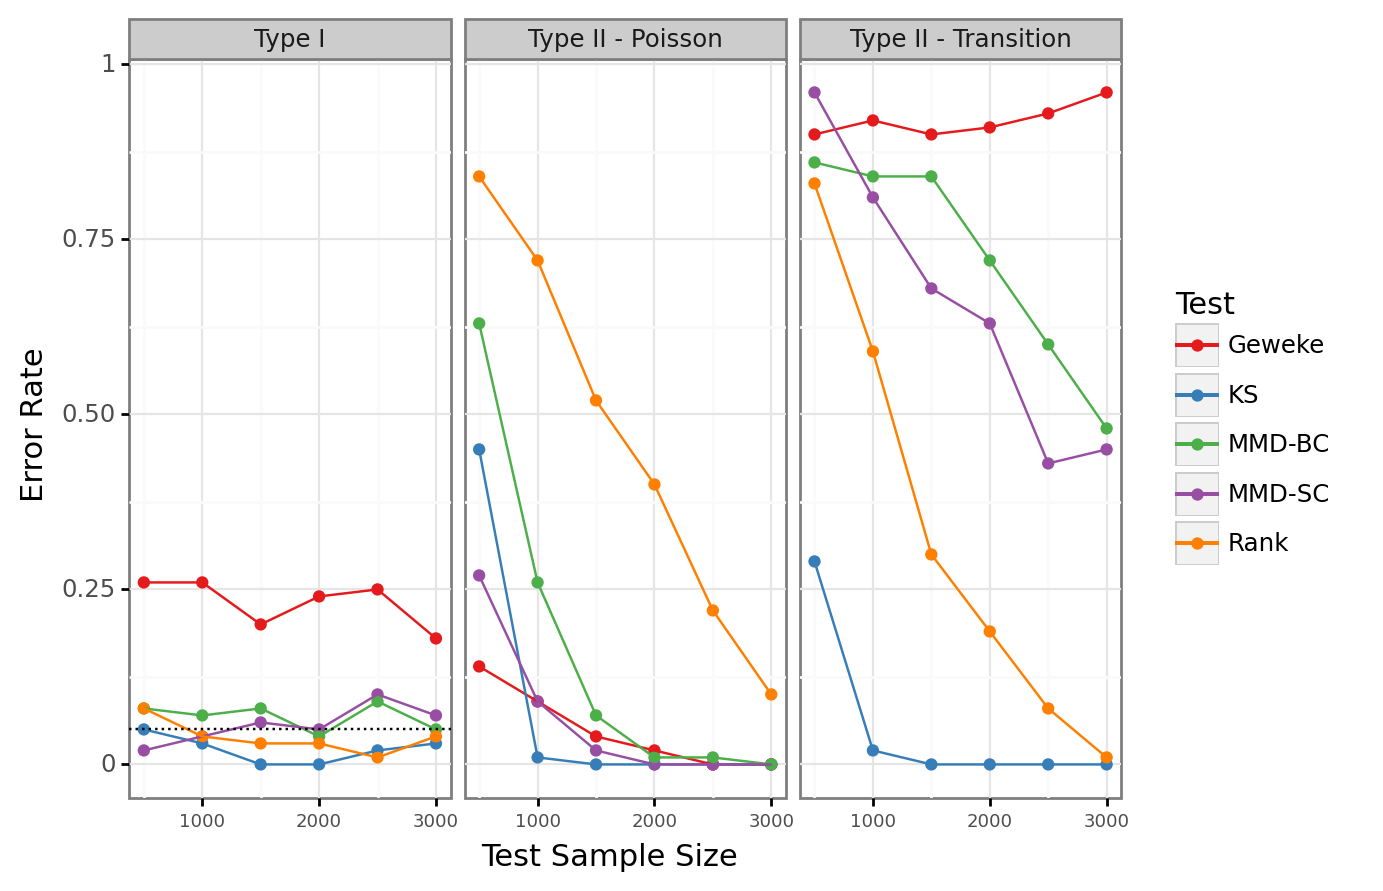

<ggplot: (8775466262179)>

In [4]:
# df_results = pd.concat(lst_res)
df_results = pd.read_pickle('bayes_lasso')

def exp_label(x):
    if 'sampler_error_1' in x:
        return 'Type II - Poisson'
    elif 'sampler_error_2' in x:
        return 'Type II - Transition'
    else:
        return 'Type I'

df_hline = pd.DataFrame({'experiment':['bayes_lasso_sampler'], 'alpha':[alpha]})
plot_results = ggplot(df_results, aes(color='test', group='test', x='test_size',  y='result')) + \
    geom_point() + geom_line() + geom_hline(df_hline, aes(yintercept='alpha'), linetype='dotted') + \
    facet_grid('~experiment', labeller=exp_label) + \
    labs(x='Test Sample Size', y='Error Rate', title='', color='Test') + \
    scale_color_discrete(labels=['Geweke', 'KS', 'MMD-BC', 'MMD-SC', 'Rank'], palette=palette) + theme_bw() +\
    theme(axis_text_x = element_text(size=6.5))
plot_results

In [ ]:
ggsave(plot_results, 'bayes_lasso_comparison.png')